<a href="https://colab.research.google.com/github/Sanjay-K-2002/Speech_Emotion_CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import soundfile as sf
import random

# Preprocessing: Extract Mel-Spectrogram Features
def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, duration=2.5, sr=22050*2)

    # Extract Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

    # Convert Mel spectrogram to dB scale (logarithmic)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    return log_mel_spectrogram

# Data Augmentation
def augment_audio(file_path):
    y, sr = librosa.load(file_path, duration=2.5, sr=22050*2)

    # Time Stretching
    y_stretch = librosa.effects.time_stretch(y, rate=random.uniform(0.8, 1.2))

    # Pitch Shifting
    y_shift = librosa.effects.pitch_shift(y, sr, n_steps=random.randint(-3, 3))

    # Add Noise
    noise = np.random.randn(len(y)) * 0.005
    y_noise = y + noise

    return y_stretch, y_shift, y_noise

# Load and Preprocess Dataset
def load_data(data_dir, augment=False):
    features = []
    labels = []

    # Read all files from the dataset directory
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)

        # If the path is a folder (emotion class), read all audio files in that folder
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(folder_path, file)
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(folder)

                    # Augmentation
                    if augment:
                        y_stretch, y_shift, y_noise = augment_audio(file_path)
                        features.extend([extract_features(y_stretch), extract_features(y_shift), extract_features(y_noise)])
                        labels.extend([folder, folder, folder])

    return np.array(features), np.array(labels)

# Prepare Data
data_dir = '/content/drive/MyDrive/RAVDESS'  # Path to your RAVDESS dataset
X, y = load_data(data_dir, augment=True)

# Preprocess Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape Data for CNN (add a channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# ResNet Model Architecture
def build_resnet_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        Conv2D(64, (3, 3), strides=(1, 1), padding="same", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding="same", activation='relu'),
        Conv2D(64, (3, 3), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding="same", activation='relu'),
        Conv2D(128, (3, 3), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), padding="same", activation='relu'),
        Conv2D(256, (3, 3), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),

        # Residual Block
        Conv2D(512, (3, 3), padding="same", activation='relu'),
        Conv2D(512, (3, 3), padding="same", activation='relu'),
        MaxPooling2D((2, 2)),

        # Global Average Pooling
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Initialize and Compile Model
model = build_resnet_model(X_train.shape[1:], len(np.unique(y)))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot Training History
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


TypeError: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

# Function to extract MFCCs from audio files
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, duration=2.5, sr=22050)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Normalize MFCCs
    mfcc = np.mean(mfcc.T, axis=0)

    return mfcc

# Data Augmentation Function
def augment_audio(file_path):
    y, sr = librosa.load(file_path, duration=2.5, sr=22050)

    # Time Stretching
    y_stretch = librosa.effects.time_stretch(y, rate=random.uniform(0.8, 1.2))

    # Pitch Shifting
    y_shift = librosa.effects.pitch_shift(y, sr, n_steps=random.randint(-3, 3))

    # Add Noise
    noise = np.random.randn(len(y)) * 0.005
    y_noise = y + noise

    return y_stretch, y_shift, y_noise

# Load and preprocess dataset
def load_data(data_dir, augment=False):
    features = []
    labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)

        # If it's a folder with emotion class
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(folder_path, file)
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(folder)

                    # Augmentation
                    if augment:
                        y_stretch, y_shift, y_noise = augment_audio(file_path)
                        features.extend([extract_features(y_stretch), extract_features(y_shift), extract_features(y_noise)])
                        labels.extend([folder, folder, folder])

    return np.array(features), np.array(labels)

# Prepare data
data_dir = '/content/drive/MyDrive/RAVDESS'  # Path to your RAVDESS dataset
X, y = load_data(data_dir, augment=True)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN input (add channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Build CNN + LSTM model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


TypeError: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install --upgrade librosa


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Paths
ravdess_path = '/content/drive/MyDrive/RAVDESS'
tess_path = '/content/drive/MyDrive/RAVDESS/archive'

# Function to load and preprocess data
def load_data(path, emotion_label_offset=0):
    lst = []
    for subdir, _, files in os.walk(path):
        for file in files:
            try:
                # Load audio file
                X, sample_rate = librosa.load(os.path.join(subdir, file), sr=None, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                # For RAVDESS: extract emotion from filename
                if "Actor" in file:
                    label = int(file[7:8]) - 1 + emotion_label_offset
                # For TESS: emotion inferred from folder name
                else:
                    label = emotion_label_offset  # Adjust if multiple emotions in TESS
                lst.append((mfccs, label))
            except Exception as e:
                print(f"Error processing file {file}: {e}")
    return zip(*lst)

# Load RAVDESS and TESS datasets
X_ravdess, y_ravdess = load_data(ravdess_path)
X_tess, y_tess = load_data(tess_path, emotion_label_offset=8)  # Offset to avoid overlapping labels

# Combine datasets
X = np.asarray(list(X_ravdess) + list(X_tess))
y = np.asarray(list(y_ravdess) + list(y_tess))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# CNN Model
model = Sequential([
    Conv1D(64, 5, padding='same', input_shape=(40, 1)),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=4),
    Conv1D(256, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    Flatten(),
    Dense(8),  # Output classes for RAVDESS (8 emotions)
    Activation('softmax')
])

# Compile the model
optimizer = RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
cnnhistory = model.fit(
    X_train_cnn, y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_test_cnn, y_test)
)

# Evaluate model
predictions = model.predict(X_test_cnn)
print(classification_report(y_test, predictions.argmax(axis=1)))

# Plot accuracy
plt.plot(cnnhistory.history['accuracy'], label='Train Accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 40, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 2, 256)              │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           4,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,672 (819.03 KB)

 Trainable params: 209,672 (819.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-23-d620f6e2f0a0>", line 77, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 359, in _compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 327, in compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 611, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 652, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 1870, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1559, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 8 which is outside the valid range of [0, 8).  Label values: 8 0 0 8 0 8 0 0 8 0 8 0 8 0 0 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_1479]

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Paths
ravdess_path = '/content/drive/MyDrive/RAVDESS'
tess_path = '/content/drive/MyDrive/RAVDESS/archive'

# Function to load and preprocess data
def load_data(path, emotion_label_offset=0):
    lst = []
    for subdir, _, files in os.walk(path):
        for file in files:
            try:
                # Load audio file
                X, sample_rate = librosa.load(os.path.join(subdir, file), sr=None, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                # For RAVDESS: extract emotion from filename
                if "Actor" in file:
                    label = int(file[7:8]) - 1 + emotion_label_offset
                # For TESS: emotion inferred from folder name
                else:
                    label = emotion_label_offset  # Adjust if multiple emotions in TESS
                lst.append((mfccs, label))
            except Exception as e:
                print(f"Error processing file {file}: {e}")
    return zip(*lst)

# Load RAVDESS and TESS datasets
X_ravdess, y_ravdess = load_data(ravdess_path)
X_tess, y_tess = load_data(tess_path, emotion_label_offset=8)  # Offset to avoid overlapping labels

# Combine datasets
X = np.asarray(list(X_ravdess) + list(X_tess))
y = np.asarray(list(y_ravdess) + list(y_tess))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Check data shapes
print(f"Train data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")

# CNN Model
model = Sequential([
    Conv1D(64, 5, padding='same', input_shape=(40, 1)),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=4),
    Conv1D(256, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    Flatten(),
    Dense(8),  # Output classes for RAVDESS (8 emotions)
    Activation('softmax')
])

# Compile the model
optimizer = RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
cnnhistory = model.fit(
    X_train_cnn, y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_test_cnn, y_test)
)

# Evaluate model
predictions = model.predict(X_test_cnn)
print(classification_report(y_test, predictions.argmax(axis=1)))

# Plot accuracy
plt.plot(cnnhistory.history['accuracy'], label='Train Accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Train data shape: (8882, 40, 1)
Test data shape: (4375, 40, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 40, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 10, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 2, 256)              │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           4,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,672 (819.03 KB)

 Trainable params: 209,672 (819.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-28-c707ea403ab5>", line 81, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 359, in _compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 327, in compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 611, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 652, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 1870, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1559, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 8 which is outside the valid range of [0, 8).  Label values: 0 0 8 0 0 8 8 8 8 0 8 0 8 0 0 8
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_4425]

Streaming output truncated to the last 5000 lines.
Error processing file YAF_book_happy.wav: invalid literal for int() with base 10: 'k'
Error processing file YAF_good_happy.wav: invalid literal for int() with base 10: 'd'
Error processing file YAF_boat_happy.wav: invalid literal for int() with base 10: 't'
Error processing file YAF_cab_happy.wav: invalid literal for int() with base 10: '_'
Error processing file YAF_goal_happy.wav: invalid literal for int() with base 10: 'l'
Error processing file YAF_bath_happy.wav: invalid literal for int() with base 10: 'h'
Error processing file YAF_chat_happy.wav: invalid literal for int() with base 10: 't'
Error processing file YAF_dead_happy.wav: invalid literal for int() with base 10: 'd'
Error processing file YAF_choice_happy.wav: invalid literal for int() with base 10: 'i'
Error processing file YAF_dog_happy.wav: invalid literal for int() with base 10: '_'
Error processing file YAF_came_happy.wav: invalid literal for int() with base 10: 'e'
Err

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 40, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 10, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 2, 256)              │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           4,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,672 (819.03 KB)

 Trainable params: 209,672 (819.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1346 - loss: 7.2678 - val_accuracy: 0.1620 - val_loss: 2.2414
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1592 - loss: 4.5684 - val_accuracy: 0.1429 - val_loss: 3.2065
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1378 - loss: 4.0701 - val_accuracy: 0.1738 - val_loss: 2.2793
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1374 - loss: 3.6501 - val_accuracy: 0.1900 - val_loss: 2.3750
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1512 - loss: 3.1396 - val_accuracy: 0.1635 - val_loss: 2.1130
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1671 - loss: 2.7420 - val_accuracy: 0.2077 - val_loss: 2.1121
Epoch 7/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1570 - loss: 2.6512 - val_accuracy: 0.1753 - val_loss: 2.0797
Epoch 8/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1920 - loss: 2.3833 - val_accuracy: 0.

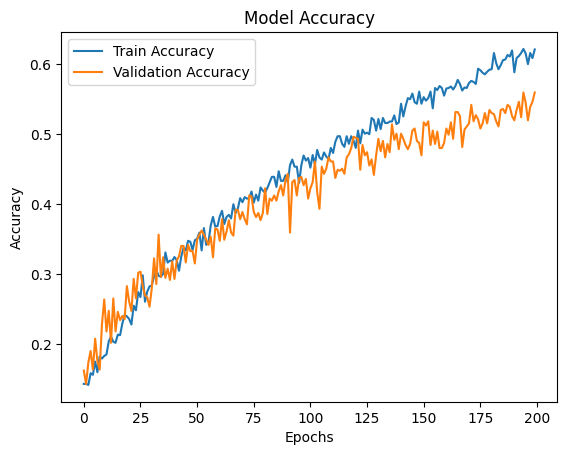

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Path
ravdess_path = '/content/drive/MyDrive/RAVDESS'

# Function to load and preprocess RAVDESS data
def load_ravdess_data(path):
    lst = []
    for subdir, _, files in os.walk(path):
        for file in files:
            try:
                # Load audio file
                X, sample_rate = librosa.load(os.path.join(subdir, file), sr=None, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                # Extract emotion label from filename
                label = int(file[7:8]) - 1  # Emotion is at position 7 in filename
                lst.append((mfccs, label))
            except Exception as e:
                print(f"Error processing file {file}: {e}")
    return zip(*lst)

# Load RAVDESS dataset
X_ravdess, y_ravdess = load_ravdess_data(ravdess_path)

# Convert to numpy arrays
X = np.asarray(list(X_ravdess))
y = np.asarray(list(y_ravdess)).astype('int')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Verify shapes
print(f"Train data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")
print(f"Unique labels: {np.unique(y_train)}")

# Get number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# CNN Model
model = Sequential([
    Conv1D(64, 5, padding='same', input_shape=(40, 1)),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    MaxPooling1D(pool_size=4),
    Conv1D(256, 5, padding='same'),
    Activation('relu'),
    Dropout(0.1),
    Flatten(),
    Dense(num_classes),  # Dynamically adjust to number of classes
    Activation('softmax')
])

# Compile the model
optimizer = RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
cnnhistory = model.fit(
    X_train_cnn, y_train,
    batch_size=16,
    epochs=200,
    validation_data=(X_test_cnn, y_test)
)

# Evaluate model
predictions = model.predict(X_test_cnn)
print(classification_report(y_test, predictions.argmax(axis=1)))

# Plot accuracy
plt.plot(cnnhistory.history['accuracy'], label='Train Accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Path
ravdess_path = '/content/drive/MyDrive/RAVDESS'

# Function to load and preprocess RAVDESS data
def load_ravdess_data(path):
    lst = []
    for subdir, _, files in os.walk(path):
        for file in files:
            try:
                # Load audio file
                X, sample_rate = librosa.load(os.path.join(subdir, file), sr=None, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                # Extract emotion label from filename
                label = int(file[7:8]) - 1  # Emotion is at position 7 in filename
                lst.append((mfccs, label))
            except Exception as e:
                print(f"Error processing file {file}: {e}")
    return zip(*lst)

# Load RAVDESS dataset
X_ravdess, y_ravdess = load_ravdess_data(ravdess_path)

# Convert to numpy arrays
X = np.asarray(list(X_ravdess))
y = np.asarray(list(y_ravdess)).astype('int')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Verify shapes
print(f"Train data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")
print(f"Unique labels: {np.unique(y_train)}")

# Get number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# CNN Model
model = Sequential([
    Conv1D(64, 5, padding='same', input_shape=(40, 1)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    MaxPooling1D(pool_size=4),
    Conv1D(256, 5, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Summary
model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
cnnhistory = model.fit(
    X_train_cnn, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stopping]
)

# Evaluate model
predictions = model.predict(X_test_cnn)
print(classification_report(y_test, predictions.argmax(axis=1)))

# Plot accuracy
plt.plot(cnnhistory.history['accuracy'], label='Train Accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Path
ravdess_path = '/content/drive/MyDrive/RAVDESS'  # Ensure this path is correct

# Function to load and preprocess RAVDESS data
def load_ravdess_data(path):
    lst = []
    for subdir, _, files in os.walk(path):
        for file in files:
            try:
                # Check if the file is an audio file (e.g., .wav)
                if not file.endswith('.wav'):
                    print(f"Skipping non-audio file: {file}")
                    continue

                # Load audio file
                file_path = os.path.join(subdir, file)
                X, sample_rate = librosa.load(file_path, sr=None, res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)

                # Extract emotion label from filename
                # RAVDESS filenames are structured as "03-01-06-01-02-01-12.wav"
                # The emotion label is the 3rd number (e.g., 06 for 'happy')
                label = int(file.split('-')[2]) - 1  # Subtract 1 to make labels 0-based
                lst.append((mfccs, label))
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    # Check if any data was loaded
    if not lst:
        raise ValueError("No data was loaded. Check the dataset path and file structure.")

    # Unzip the list of tuples into separate lists
    return zip(*lst)

# Load RAVDESS dataset
X_ravdess, y_ravdess = load_ravdess_data(ravdess_path)

# Convert to numpy arrays
X = np.asarray(list(X_ravdess))
y = np.asarray(list(y_ravdess)).astype('int')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Verify shapes
print(f"Train data shape: {X_train_cnn.shape}")
print(f"Test data shape: {X_test_cnn.shape}")
print(f"Unique labels: {np.unique(y_train)}")

# Get number of classes
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# CNN Model
model = Sequential([
    Conv1D(64, 5, padding='same', input_shape=(40, 1)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    MaxPooling1D(pool_size=4),
    Conv1D(256, 5, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model Summary
model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
cnnhistory = model.fit(
    X_train_cnn, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stopping]
)

# Evaluate model
predictions = model.predict(X_test_cnn)
print(classification_report(y_test, predictions.argmax(axis=1)))

# Plot accuracy
plt.plot(cnnhistory.history['accuracy'], label='Train Accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()